# Performance metric function behavior plot

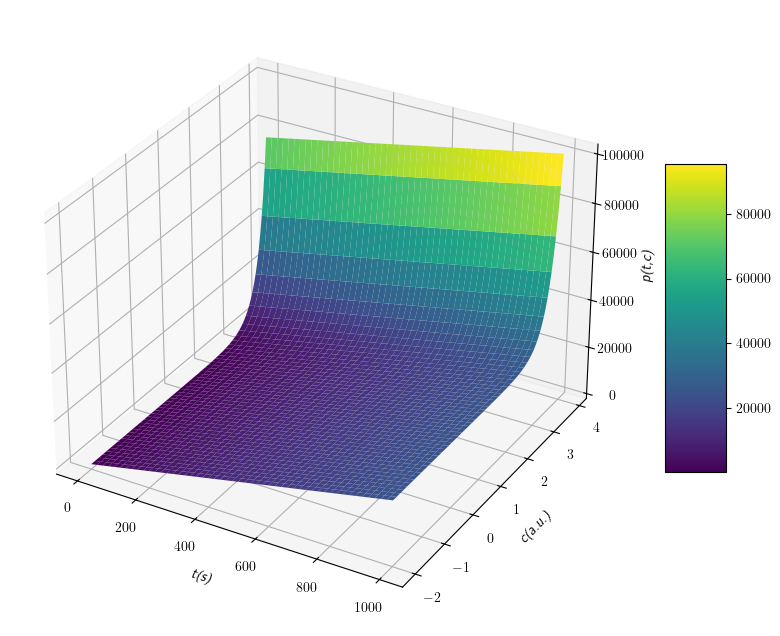

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({
  "text.usetex": True,
  #"font.family": "Helvetica"
})

# Constants
a = 25
b = 3
epsilon = 0.1

# Function definition from the image
def p_function(t, c):
    return a * t + np.heaviside(c - (0 + np.abs(epsilon)),1)*np.exp(b * (c - (0 + np.abs(epsilon))))

# Generate mesh grid for t and c
t_vals = np.linspace(0, 1000, 400)
c_vals = np.linspace(-2, 3.85, 100)
T, C = np.meshgrid(t_vals, c_vals)

# Compute p for each t, c
P = p_function(T, C)

# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(T, C, P, cmap='viridis')

# Labels and title
ax.set_xlabel('\\textit{t(s)}')
ax.set_ylabel('\\textit{c(a.u.)')
ax.set_zlabel('\\textit{p(t,c)}')
#ax.set_title('3D Plot of performance metric')

# Add color bar for the surface plot
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Show plot
from pathlib import Path
import os
notebook_path = os.path.dirname(os.path.realpath("__file__"))
out_path=notebook_path+"/optimizer_plot_outputs/performance_metric_behavior.pdf"
Path(out_path).parent.mkdir(parents=True, exist_ok=True)
plt.savefig(out_path)

plt.show()

# Hyperparameter optimization plots for reduced BCS Hamiltonian for 10000 gens

In [2]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import openfermion as of
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
#import covvqetools as cov

plt.rcParams.update({
  "text.usetex": True,
  #"font.family": "Helvetica"
})

notebook_path = os.path.dirname(os.path.realpath("__file__"))
data_dir = notebook_path+'/optimizer_hp_tuning_data/10000gens'
data = pd.read_json(data_dir+'/optimizer_hyperparameter_tuning.json')

In [3]:
optimal_cost=data[data['optimizer']=='ModelGrad'].optimal_cost.unique()[0]
optimal_cost

4.7822974375000005

In [4]:
#establishing the true optimal cost function value
nact =4
rg_hamilt_dict = {"g": -0.9, "nact": nact}
npairs = nact // 2
rg_hamiltonian = of.hamiltonians.RichardsonGaudin(rg_hamilt_dict["g"], nact)
hamiltonian = rg_hamiltonian.qubit_operator
target_energy, target_state = of.linalg.jw_get_ground_state_at_particle_number(
of.get_sparse_operator(hamiltonian), npairs)
target_energy

4.782297437528603

In [5]:
for opt in data.opt_name.dropna().unique():
    print(f'Starting hyperparameters for optimizer:{opt}')
    print(np.array(data[data['opt_name']==str(opt)].accepted_hyper_params)[0], '\n')
    print(f'Optimal hyperparameters for optimizer: {opt}')
    hp_params_dict=np.array(data[data['opt_name']==str(opt)].accepted_hyper_params)[-1]
    print(hp_params_dict, '\n')

Starting hyperparameters for optimizer:SPSA
{'scaling_param': 0.11, 'scaling_exponent': 0.101, 'grad_scaling_param': 1.5, 'grad_scaling_exponent': 0.6000000000000001, 'grad_stability_constant': 600, 'shots': 2000000.0} 

Optimal hyperparameters for optimizer: SPSA
{'scaling_param': 0.097, 'scaling_exponent': 0.166, 'grad_scaling_param': 0.338, 'grad_scaling_exponent': 0.125, 'grad_stability_constant': 599, 'shots': 108137.502} 

Starting hyperparameters for optimizer:ModelGrad
{'sample_radius': 1.0, 'learning_rate': 0.15, 'stability_constant': 10, 'eta': 1.0, 'sample_radius_decay_exponent': 0.5, 'rate_decay_exponent': 0.2, 'shots': 5000} 

Optimal hyperparameters for optimizer: ModelGrad
{'sample_radius': 0.894, 'learning_rate': 1.003, 'stability_constant': 8, 'eta': 0.243, 'sample_radius_decay_exponent': 0, 'rate_decay_exponent': 0.176, 'shots': 485} 

Starting hyperparameters for optimizer:Rotosolve
{'shots': 1000} 

Optimal hyperparameters for optimizer: Rotosolve
{'shots': 50} 

St

In [6]:
unique_hyper_params=['sample_radius',
 'grad_scaling_exponent',
 'grad_stability_constant',
 'scaling_param',
 'sample_radius_decay_exponent',
 'grad_scaling_param',
 'eta',
 'learning_rate',
 'rate_decay_exponent',
 'scaling_exponent',
 'shots',
 'stability_constant']

In [7]:
unique_hp_dict={
    'sample_radius':'Sample Radius',
    'grad_scaling_exponent':"Gradient Scaling Exponent",
    'grad_stability_constant':"Gradient Stability Constant",
    'scaling_param':"Scaling Parameter",
    'sample_radius_decay_exponent':"Sample Radius Decay Exponent" ,
    'grad_scaling_param':"Gradient Scaling Parameter",
    'eta':"Eta" ,
    'learning_rate':"Learning Rate",
    'rate_decay_exponent':"Learning Rate Decay Exponent",
    'scaling_exponent':"Scaling Exponent",
    'shots':"Shots",
    'stability_constant':"Stability Constant" 
}

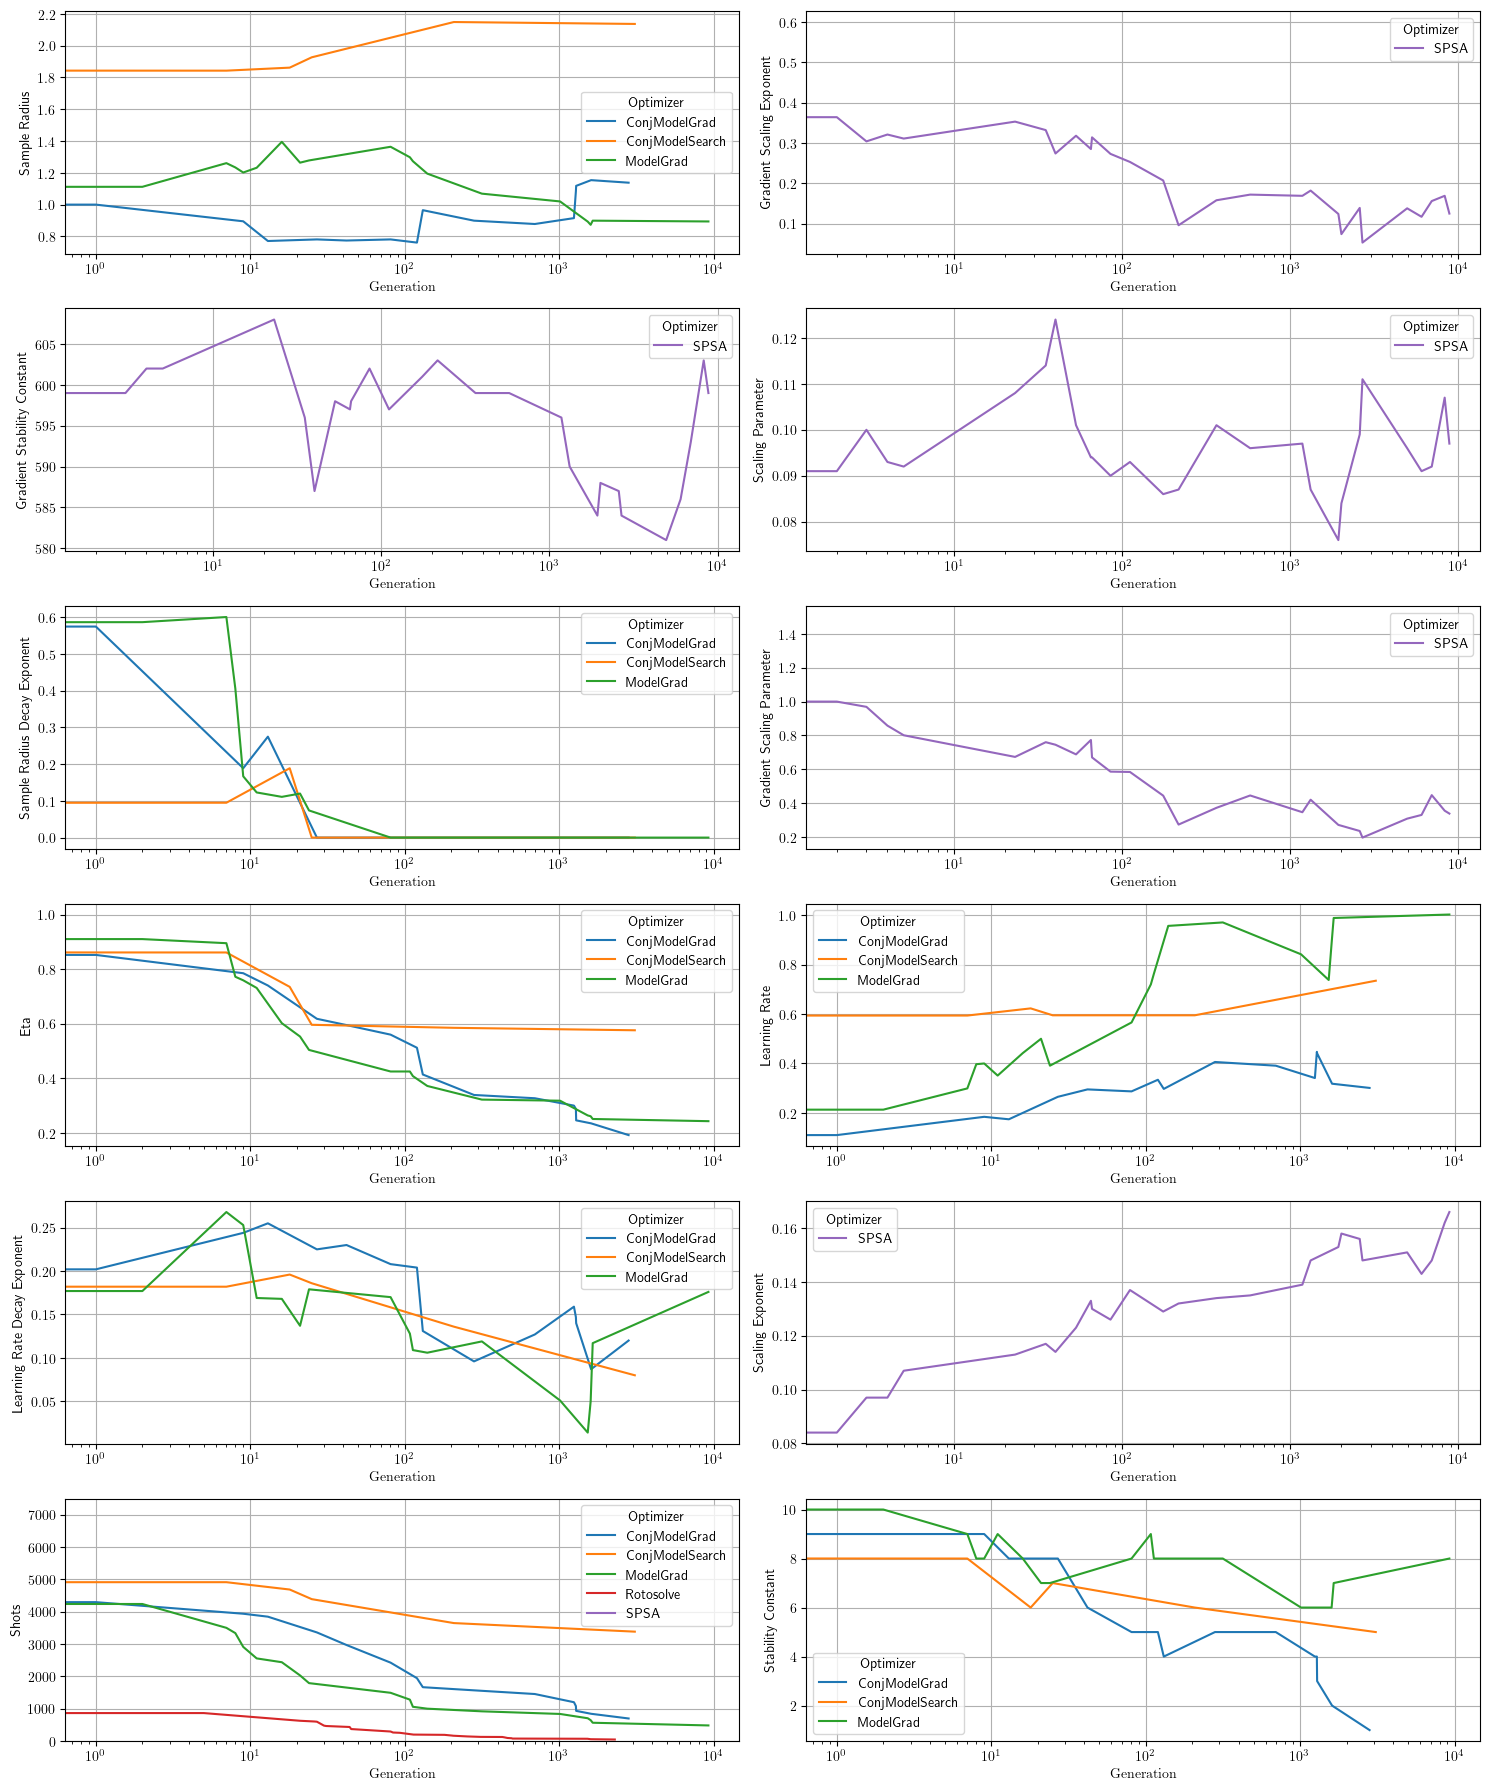

In [8]:
plot_kwargs = {
    #'markers':True,
    'alpha':1.0,
    #'units':'optimizer_run',
    #'estimator':None,
    }
palette_colors = sns.color_palette('tab10')

color_dict = {
    'ConjModelGrad': 'tab:blue',
    'ConjModelSearch': 'tab:orange',
    'ModelGrad': 'tab:green',
    'Rotosolve': 'tab:red',
    'SPSA': 'tab:purple'
}

fig, axs = plt.subplots(6, 2, figsize=(15, 18))
axs = axs.flatten()  # Flatten the 2D array of axes for easier iteration.

for idx, hyper_param in enumerate(unique_hyper_params):
    ax = axs[idx]
    
    for opt_name, group in data.groupby('opt_name'):
        if group[hyper_param].notna().any():
            ax.plot(
                group['gen'], 
                group[hyper_param], 
                label=opt_name, 
                color=color_dict.get(opt_name, None),
                **plot_kwargs
            )
    
    ax.set_xscale("log")
    if hyper_param == 'shots':
        ax.set_ylim(0,7500)
    ax.set_xlabel(r'$\textrm{Generation}$')
    y_name = unique_hp_dict[hyper_param]
    ax.set_ylabel(y_name)
    ax.grid(True)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(title="Optimizer")

plt.tight_layout()
from pathlib import Path
out_path=notebook_path+"/optimizer_hp_tuning_plots/hyper_params_over_generations.pdf"
Path(out_path).parent.mkdir(parents=True, exist_ok=True)
plt.savefig(out_path)
plt.show()

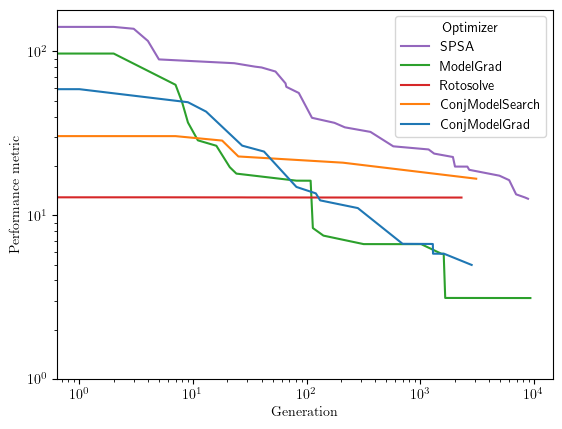

In [9]:
color_dict = {
    'ConjModelGrad': 'tab:blue',
    'ConjModelSearch': 'tab:orange',
    'ModelGrad': 'tab:green',
    'Rotosolve': 'tab:red',
    'SPSA': 'tab:purple'
}

ax = sns.lineplot(
        data=data,#filtdata,
        y='performance_metric', 
        x='gen', 
        hue='opt_name',
        #style='optimizer',
        #units='optimizer_run',
        #hue_order=hue_order,
        palette=color_dict,
        #err_style='band',
        **plot_kwargs
        )
ax.set(yscale="log")
ax.set(xscale="log")
ax.set_ylabel(r'$\textrm{Performance metric}$')
ax.set_xlabel(r'$\textrm{Generation}$')
ax.set(ylim=(1,180))
ax.legend(title="Optimizer")
from pathlib import Path
out_path=notebook_path+"/optimizer_hp_tuning_plots/performance_metrics.pdf"
Path(out_path).parent.mkdir(parents=True, exist_ok=True)
plt.savefig(out_path)
plt.show()


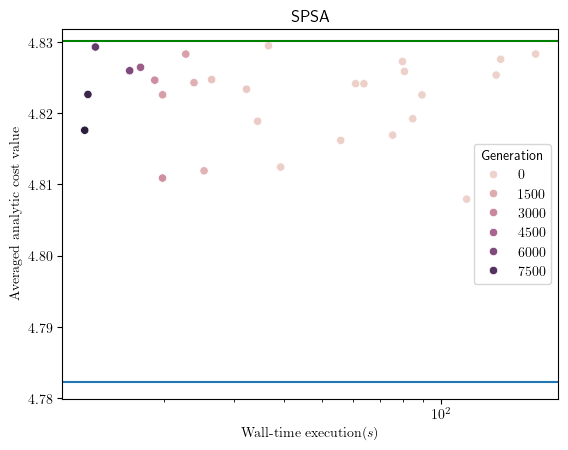

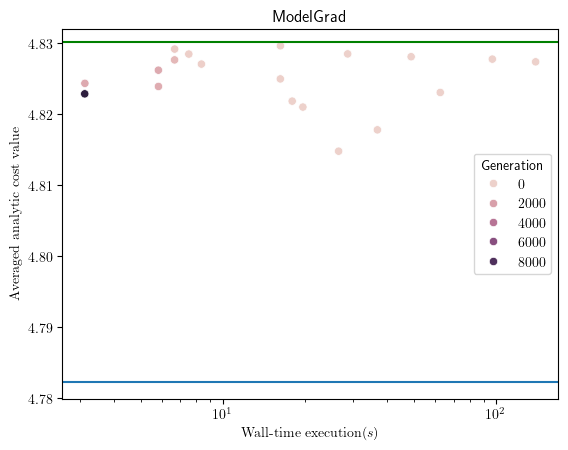

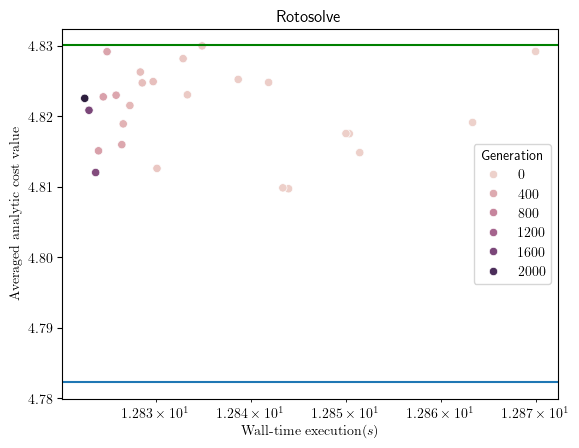

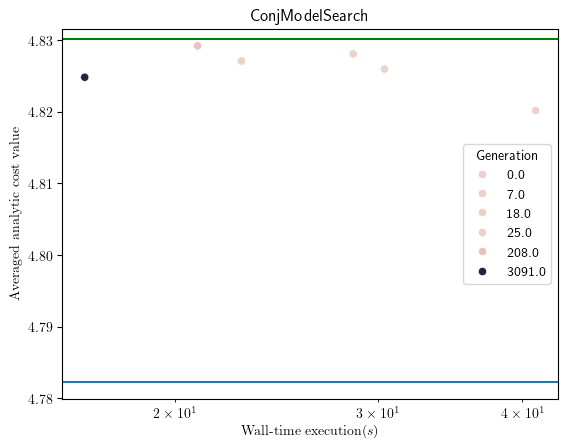

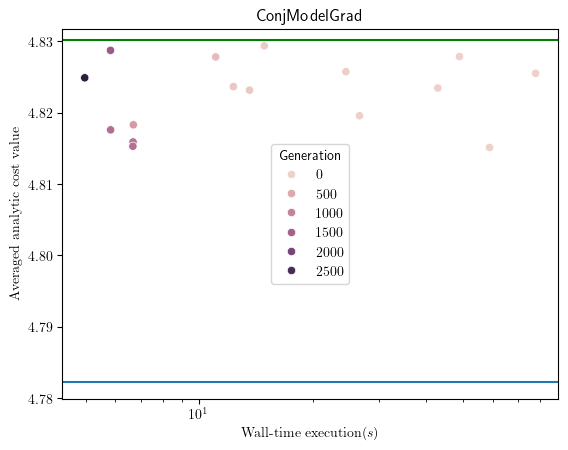

In [10]:
for opt in data.opt_name.dropna().unique():
    filt_data = data[data['opt_name']==opt]
    ax = sns.scatterplot(
        data=filt_data,
        y='averaged_analytic_cost_value',
        x='full_optimization_walltime', 
        hue='gen',
        #style='opt_name',
        #units='optimizer_run',
        #hue_order=hue_order,
        #palette=palette_dict,
        #err_style='band',
        **plot_kwargs
        )
    ax.set(xscale="log")
    #ax.set(yscale="log")
    plt.axhline(y=optimal_cost)
    #plt.axhline(y=optimal_cost+1e-3, color='g', label='etol')
    plt.axhline(y=optimal_cost+1e-2*optimal_cost, color='g')
    ax.set_ylabel(r'$\textrm{Averaged analytic cost value}$')
    ax.set_xlabel(r'$\textrm{Wall-time execution} (s)$')
    plt.title('{}'.format(opt))
    ax.legend(title="Generation")
    #plt.axhline(y=target_energy, color='r', label='true_target')
    from pathlib import Path
    out_path=notebook_path+"/optimizer_hp_tuning_plots/avg_analytic_cost_values_over_walltime/"+str(opt)+"_avg_an_cv_over_walltime.pdf"
    Path(out_path).parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path)
    plt.show()

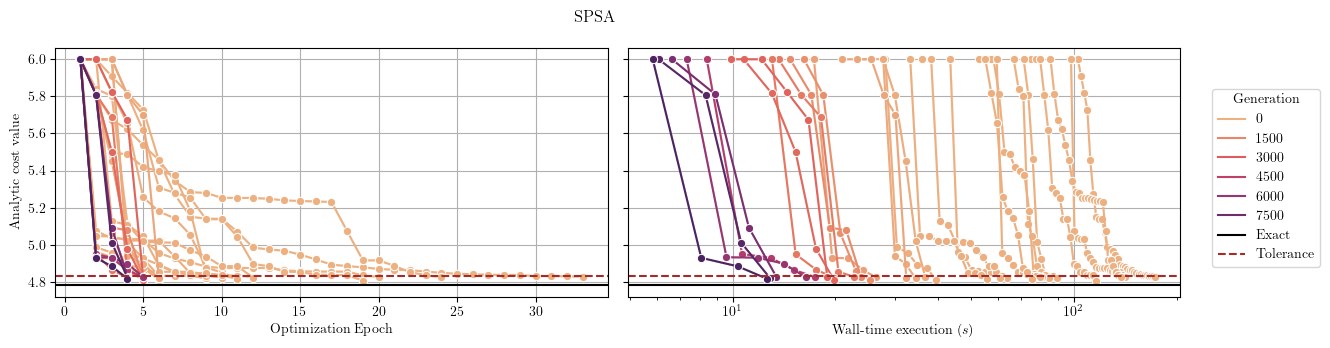

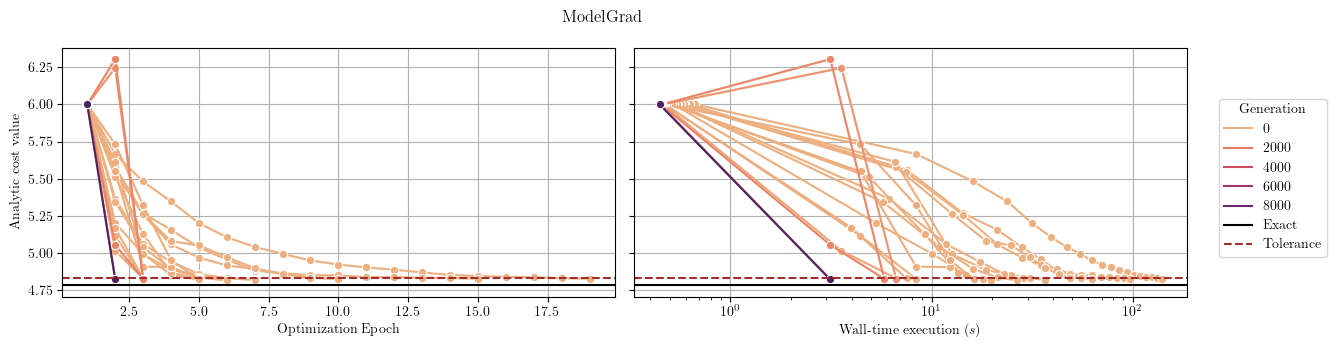

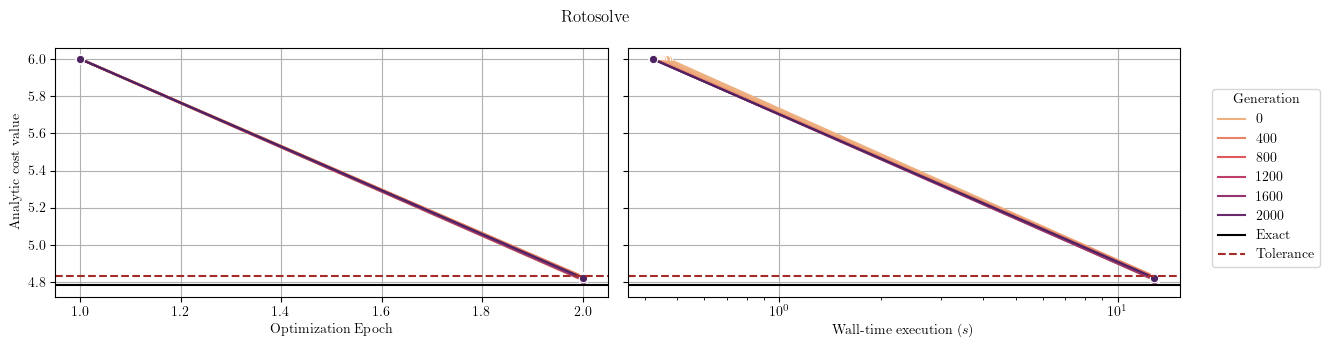

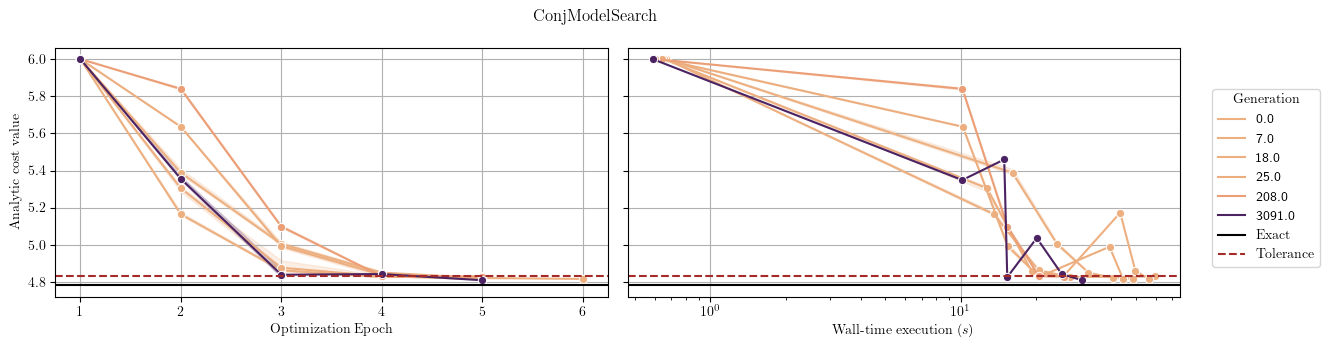

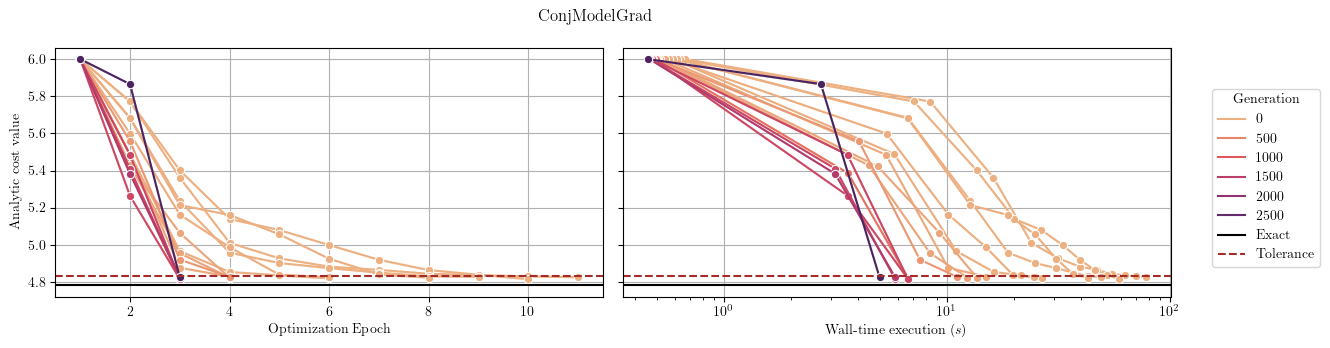

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.colors as mcolors
import numpy as np

# Get the unique optimizer names from the 'optimizer' column.
optimizers = data.optimizer.dropna().unique()  # should be 5 optimizers
cmap_dict={'ConjModelGrad': 'Blues',
 'ConjModelSearch': 'Oranges',
 'ModelGrad': 'Greens',
 'Rotosolve': 'Reds',
 'SPSA': 'Purples'}

for i, opt in enumerate(optimizers):
    # Filter data using the 'optimizer' column.
    filt_data = data[data['optimizer'] == opt]
    filt_data.loc[:, 'generation'] = filt_data['generation'].astype(int)

    # Create a figure with 5 rows and 2 columns.
    fig, axs = plt.subplots(1, 2,figsize=(12,3.5),sharey=True)

    # Left subplot: analytic_cost_value vs. epoch.
    ax_left = axs[0]
    sns.lineplot(
        data=filt_data,
        x='epoch',
        y='analytic_cost_value',
        hue='generation',#filt_data['generation'].astype(int),
        style='optimizer',
        palette=sns.color_palette("flare", as_cmap=True),
        markers=True,
        ax=ax_left
    )
    #ax_left.set(xscale="log")
    ax_left.axhline(y=optimal_cost, color='black', linestyle='-')
    ax_left.axhline(y=optimal_cost + 1e-2 * optimal_cost, color='brown', linestyle='--', label='etol')
    ax_left.set_xlabel(r'$\textrm{Optimization Epoch}$')
    ax_left.set_ylabel(r'$\textrm{Analytic cost value}$')

    # Right subplot: analytic_cost_value vs. wall_time_execution.
    ax_right = axs[1]
    sns.lineplot(
        data=filt_data,
        x='wall_time_execution',
        y='analytic_cost_value',
        hue='generation',
        style='optimizer',
        palette=sns.color_palette("flare", as_cmap=True),
        markers=True,
        ax=ax_right
    )
    ax_right.set(xscale="log")
    ax_right.axhline(y=optimal_cost, color='black', linestyle='-', label=r'$\textrm{Exact}$')
    ax_right.axhline(y=optimal_cost + 1e-2 * optimal_cost, color='brown', linestyle='--', label=r'$\textrm{Tolerance}$')
    ax_right.set_xlabel(r'$\textrm{Wall-time execution }(s)$')
    ax_right.set_ylabel(r'$\textrm{Analytic cost value}$')

    fig.suptitle(r'$\textrm{'+str(opt)+'}$')
    handles, labels = ax_right.get_legend_handles_labels()
    handles_no_style = [h[0] if isinstance(h, tuple) else h for h in handles]

    # Remove 'generation', 'optimizer', and 'SPSA' from labels
    filtered_handles = []
    filtered_labels = []

    for handle, label in zip(handles_no_style, labels):
        if label != 'generation' and label != 'optimizer' and label != opt:
            filtered_handles.append(handle)
            filtered_labels.append(label)

    if ax_left.get_legend() is not None:
        ax_left.get_legend().remove()
    if ax_right.get_legend() is not None:
        ax_right.get_legend().remove()
    fig.legend(filtered_handles, filtered_labels, bbox_to_anchor=(1.11, 0.5), title=r'$\textrm{Generation}$', loc='outside right')
    ax_right.grid(True)
    ax_left.grid(True)
    # Adjust layout to prevent overlapping.
    fig.tight_layout()

    # Save the combined figure.
    out_path = notebook_path + "/optimizer_hp_tuning_plots/analytic_cost_values/optimizer_combined_figure_" + str(opt) + ".pdf"
    Path(out_path).parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, bbox_inches='tight')
    plt.show()

# Performance comparison

## Performance comparison using no shot noise

In [12]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plt.rcParams.update({
  "text.usetex": True,
  #"font.family": "Helvetica"
})

notebook_path = os.path.dirname(os.path.realpath("__file__"))

noiseless_file_paths={
    '6':notebook_path+'/optimizer_hp_comparison_data/rg4_to_6/hyperparam_scaling_comparison_rg4_to_rg6',
    '8':notebook_path+'/optimizer_hp_comparison_data/rg4_to_8/hyperparam_scaling_comparison_rg4_to_rg8',
    '10':notebook_path+'/optimizer_hp_comparison_data/rg4_to_10/hyperparam_scaling_comparison_rg4_to_rg10',
}


Tolerance percentage of convergence for system size 6 is: 5.0%


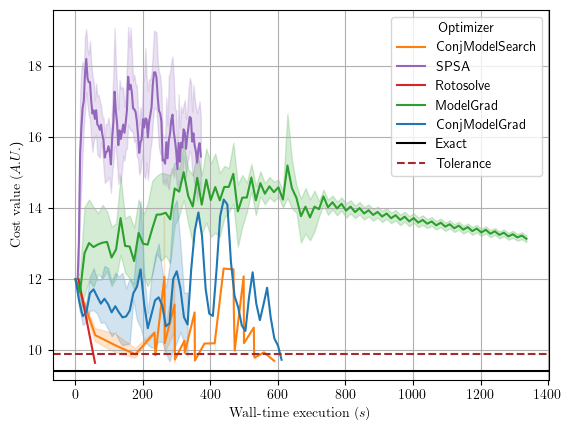

Tolerance percentage of convergence for system size 8 is: 5.0%


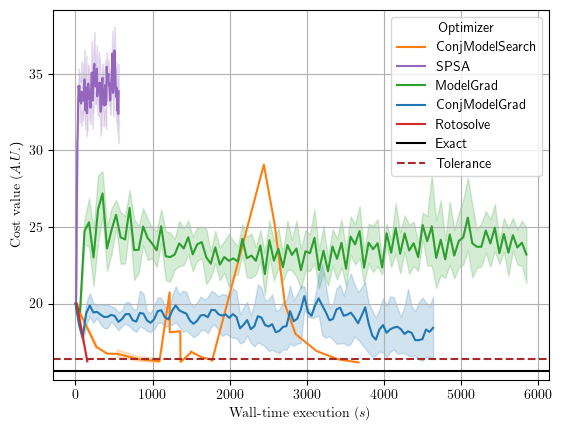

Tolerance percentage of convergence for system size 10 is: 5.0%


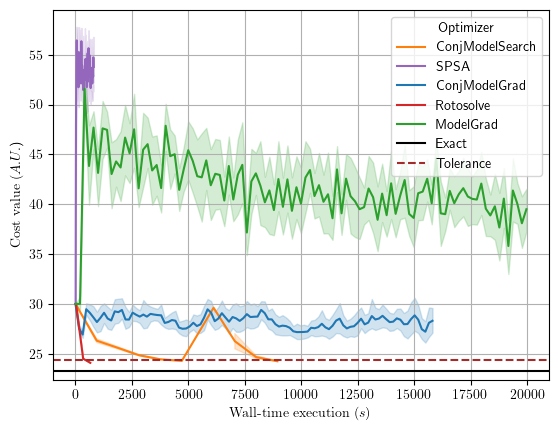

In [13]:
color_dict = {
    'ConjModelGrad': 'tab:blue',
    'ConjModelSearch': 'tab:orange',
    'ModelGrad': 'tab:green',
    'Rotosolve': 'tab:red',
    'SPSA': 'tab:purple'
}

for size, path in noiseless_file_paths.items():
    noiseless_data=pd.read_json(path+'/rg4_to_'+size+'_noiseless.json')

    noiseless_true_cost=noiseless_data.true_optimal_cost.dropna().unique()[0]
    noiseless_mod_cost=noiseless_data.modified_optimal_cost.dropna().unique()[0]

    print(f'Tolerance percentage of convergence for system size {size} is: {np.round((noiseless_mod_cost-noiseless_true_cost)/noiseless_true_cost, 3)*100}%')

    ax = sns.lineplot(
            data=noiseless_data[noiseless_data['opt_hp']==True],
            y='cost_value',
            x='wall_time_execution', 
            #x='epoch',
            hue='optimizer',
            #style='opt_hp',
            #units='optimizer_run',
            #hue_order=hue_order,
            palette=color_dict,
            #err_style='band',
            **plot_kwargs
            )
        #ax.set(xscale="log")
        #ax.set(yscale="log")
    # plt.axhline(y=optimal_cost)
    plt.axhline(y=noiseless_true_cost, linestyle='-', color='k',label='Exact')
    plt.axhline(y=noiseless_mod_cost, linestyle='--', color='brown',label='Tolerance')
    #plt.axhline(y=true_cost)
    ax.set_ylabel(r'$\textrm{Cost value }(A.U.$)')
    ax.set_xlabel(r'$\textrm{Wall-time execution }(s)$')
    ax.legend(title='Optimizer')
    ax.grid(True)
    from pathlib import Path
    out_path=notebook_path+"/optimizer_hp_comparison_plots/"+"opt_comparison_cv_over_walltime_rg4_to_"+size+"_noiseless.pdf"
    Path(out_path).parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path)
    plt.show()

# Performance comparison using (fake) shot noise

In [14]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plt.rcParams.update({
  "text.usetex": True,
  #"font.family": "Helvetica"
})

notebook_path = os.path.dirname(os.path.realpath("__file__"))

noisy_file_paths={
    '6':notebook_path+'/optimizer_hp_comparison_data/rg4_to_6/hyperparam_scaling_comparison_rg4_to_rg6_fake_noise',
    '8':notebook_path+'/optimizer_hp_comparison_data/rg4_to_8/hyperparam_scaling_comparison_rg4_to_rg8_fake_noise',
    '10':notebook_path+'/optimizer_hp_comparison_data/rg4_to_10/hyperparam_scaling_comparison_rg4_to_rg10_fake_noise',
}

Tolerance percentage of convergence for system size 6 is: 5.0%


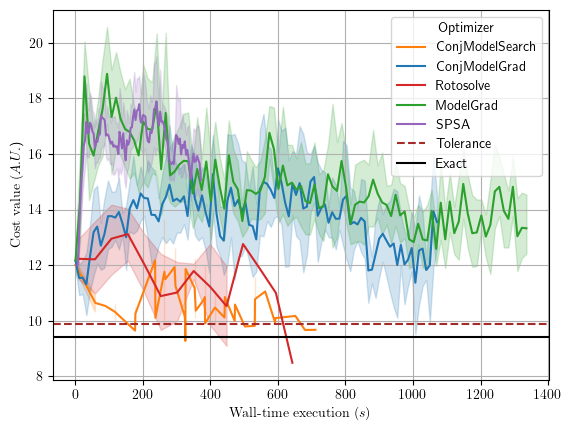

Tolerance percentage of convergence for system size 8 is: 5.0%


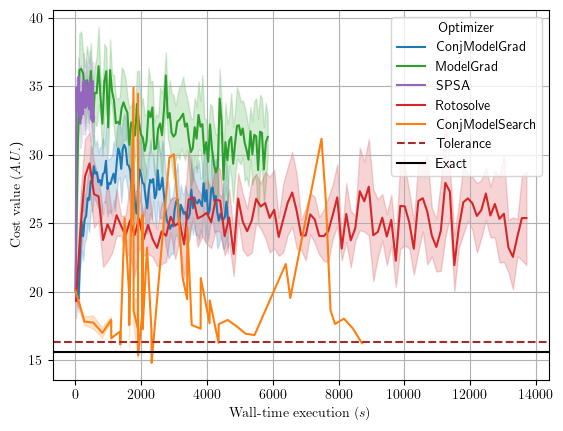

Tolerance percentage of convergence for system size 10 is: 5.0%


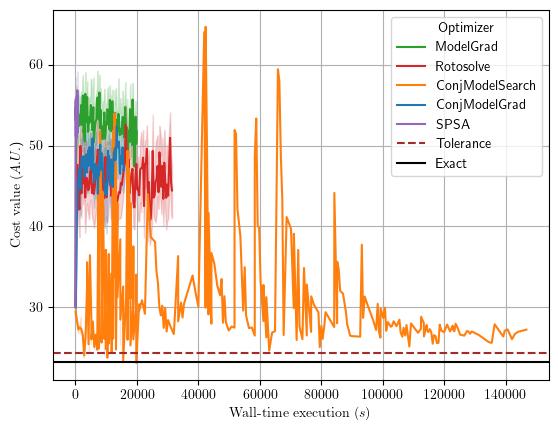

In [15]:
color_dict = {
    'ConjModelGrad': 'tab:blue',
    'ConjModelSearch': 'tab:orange',
    'ModelGrad': 'tab:green',
    'Rotosolve': 'tab:red',
    'SPSA': 'tab:purple'
    }

for size, path in noisy_file_paths.items():
    noisy_data=pd.read_json(path+'/rg4_to_'+size+'_fake_noise.json')

    noisy_true_cost=noisy_data.true_optimal_cost.dropna().unique()[0]
    noisy_mod_cost=noisy_data.modified_optimal_cost.dropna().unique()[0]

    print(f'Tolerance percentage of convergence for system size {size} is: {np.round((noisy_mod_cost-noisy_true_cost)/noisy_true_cost, 3)*100}%')

    ax = sns.lineplot(
            data=noisy_data[noisy_data['opt_hp']==True],
            y='cost_value',
            x='wall_time_execution', 
            hue='optimizer',
            palette=color_dict,
            **plot_kwargs
            )
    plt.axhline(y=noisy_mod_cost, linestyle='--', color='brown',label='Tolerance')
    plt.axhline(y=noisy_true_cost, linestyle='-', color='k',label='Exact')
    
    ax.set_ylabel(r'$\textrm{Cost value }(A.U.$)')
    ax.set_xlabel(r'$\textrm{Wall-time execution }(s)$')
    ax.legend(title='Optimizer')
    ax.grid(True)
    from pathlib import Path
    out_path=notebook_path+"/optimizer_hp_comparison_plots/"+"opt_comparison_cv_over_walltime_rg4_to_"+size+"_fake_noise.pdf"
    Path(out_path).parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path)
    plt.show()